In [1]:
import os
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = glob.glob("*.csv")[0]

In [3]:
data = pd.read_csv(filename)

In [178]:
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,75,82,114,147,177,212,272,322,411,599
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,701,773,839,825,878,889,924,963,1007,1086
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,200,212,226,243,266,313,345,385,432,455
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,2
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,197,238,428,566,673,790,900,1030,1183,1306


In [5]:
data.columns[-1] #most recent date in data

'3/22/20'

In [6]:
countries = data.sort_values("Country/Region")["Country/Region"].unique()

In [7]:
dates = data.columns[4:]

In [8]:
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20'],
      dtype='object')

**Plotting growth for a country**

In [9]:
from matplotlib.dates import DateFormatter

In [280]:
def plot_date(df, country="India", days=None):
    
    start = 4
    end = df.shape[1]
    
    if days:
        end = min(start+days, end)
    days = end-start
    

    x = df.columns[start:end]
    #x=np.arange(len(x))
    index = df[df["Country/Region"]==country].index[0]
    y = df.loc[index, :][start:end]
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
    
    myFmt = DateFormatter("%d")
    plt.gcf().autofmt_xdate()
    plt.xlabel(str(days)+" days")
    plt.ylabel(country)
    
    xmarks=[i for i in range(1,days,5)]
    plt.xticks(xmarks, rotation=90)
    plt.show()

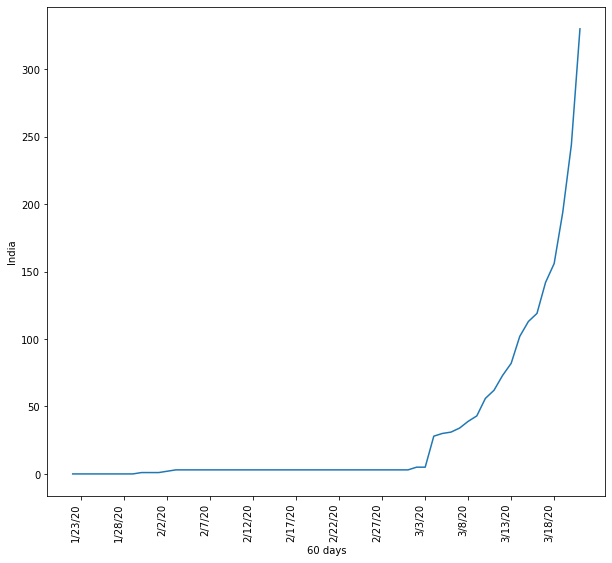

In [281]:
plot_date(data, "India", 60)

**Grouping base on countries** (Learnings: Refreshed Grouping)

In [12]:
grouped = data.groupby(["Country/Region"]).sum().reset_index()

In [13]:
grouped[grouped["Country/Region"]=="China"]

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
33,China,1083.3367,3684.4197,548,643,920,1406,2075,2877,5509,...,80945,80977,81003,81033,81058,81102,81156,81250,81305,81397


**Top-n countries with most cases on the last registered date** (Learning: Grouping and pie plotting)

In [97]:
def plot_pie_top(grouped_df, k, return_list=False):
    
    #Top countries with highest numbers till last date
    last_date = grouped_df.columns[-1]
    top_countries = grouped_df.nlargest(k, last_date)[["Country/Region", last_date]]
    
    
    #Other countries not in top list
    remaining_c = [c not in top_countries["Country/Region"].values for c in countries]
    remaining = grouped.loc[remaining_c]
    rem_sum = remaining.iloc[:, -1].sum()
    
    #Appending remainig to top list as "Others"
    top_countries=top_countries.append({
        "Country/Region":"Others",
        last_date: rem_sum
    }, ignore_index=True)
    
    #print(top_countries)
    
    explode  = [0]*(k+1)
    explode[1] = 0.1
    
    plt.figure(figsize=(10,10))
    plt.title("top "+ str(k) + " countries as of " + str(last_date))
    plt.pie(top_countries.iloc[:, 1], 
            labels=top_countries.iloc[:, 0], 
            explode=explode,
            autopct='%1.1f%%'
           )
    plt.show()
    
    if return_list:
        return top_countries["Country/Region"].values
    

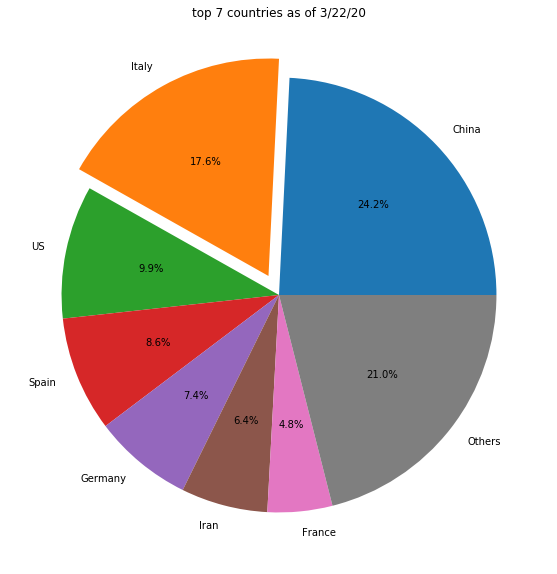

In [99]:
plot_pie_top(grouped, 7)

**Findings:** China and Italy combined with US has almost 50% of total cases in the world as of now

Lets look at worldwide growth

In [102]:
def plot_date_global(df, days=None):
    
    start = 4
    end = df.shape[1]
    if days:
        end = min(start+days, end)
    days = end-start

    x = df.columns[start:end]    
    y = grouped.iloc[:, 4:].sum().values
    
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
    
    myFmt = DateFormatter("%d")
    plt.gcf().autofmt_xdate()
    plt.xlabel(str(days)+" days")
    plt.ylabel("Global")
    plt.show()

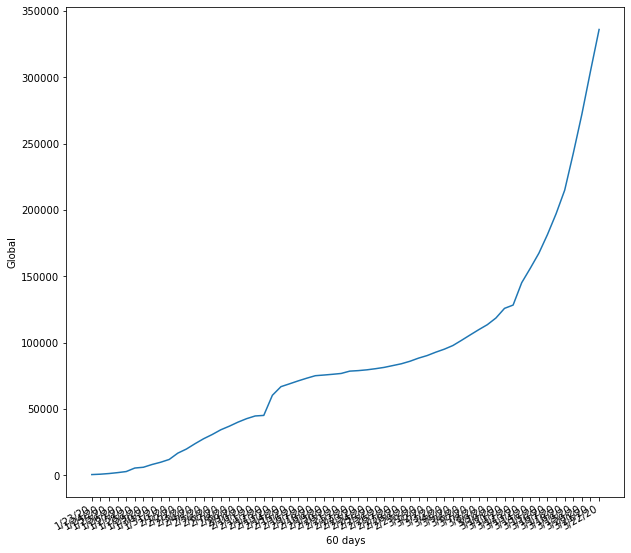

In [103]:
plot_date_global(grouped, 70)

Lets see what were the situations on a particular country on a given date

Let's get some insights on how mane cases were there on a day

In [282]:
def plot_on_date(df, date, countries=None):    
    
    top_countries = df.nlargest(5, date)[["Country/Region", date]]
    
    cs = top_countries["Country/Region"].values
    
    if type(countries) == np.ndarray:
        cs = countries
        
    filtered = df[df["Country/Region"].isin(cs)]
    
    on_date = filtered[["Country/Region", date]].sort_values([date])
    print(on_date)
    conn= on_date.iloc[:, 0].values
    vals = on_date.iloc[:, 1].values
    plt.figure(figsize=(10,10))
    plt.bar(conn, vals)
    plt.xticks(rotation="30")
    plt.show()
    

    Country/Region  3/7/20
45        Djibouti       0
72        Honduras       0
117        Nigeria       1
158        Tunisia       1
10      Azerbaijan       9
50           Egypt      15
83           Japan     461


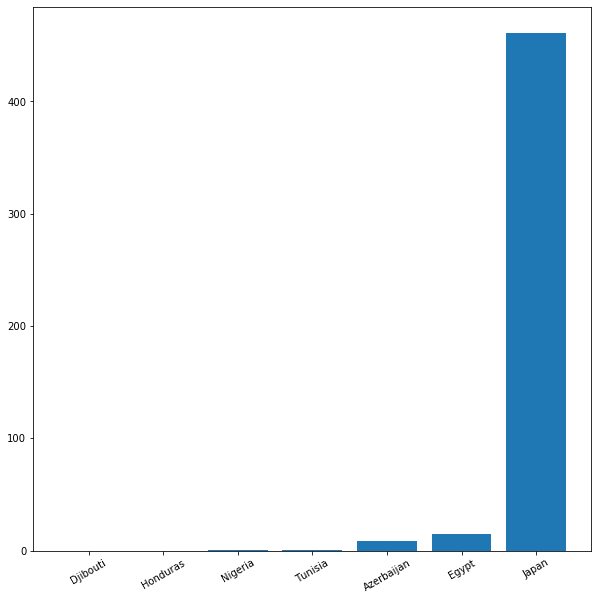

In [285]:
plot_on_date(grouped, dates[45] , countries[np.random.randint(0, len(countries), 7)])

In [290]:
#for a single country, Can be used for plotting multiple countries!
def plot_difference(df, country, days):
    start = 4
    end = df.shape[1]
    
    if days:
        end = min(start+days, end)
    days = end-start
    
    x = df.columns[start:end]
    index = df[df["Country/Region"]==country].index[0]
    y = df.loc[index, :][start:end]
    #print(y)
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
    
    myFmt = DateFormatter("%d")
    plt.gcf().autofmt_xdate()
    plt.xlabel(str(days)+" days")
    plt.ylabel(country)
    plt.title("Daily difference")
    
    xmarks=[i for i in range(1,days,5)]
    plt.xticks(xmarks, rotation=90)
    plt.show()

In [291]:
cols = [c for c in grouped.columns if c not in [dates[0]]]
daily_difference = grouped.loc[:, cols].copy()
daily_difference.loc[:, cols[3:]] = grouped[dates[1:]].values-grouped[dates[:-1]].values
daily_difference[daily_difference["Country/Region"]=="China"]

,Country/Region,Lat,Long,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
33,China,1083.3367,3684.4197,95,277,486,669,802,2632,578,...,13,32,26,30,25,44,54,94,55,92


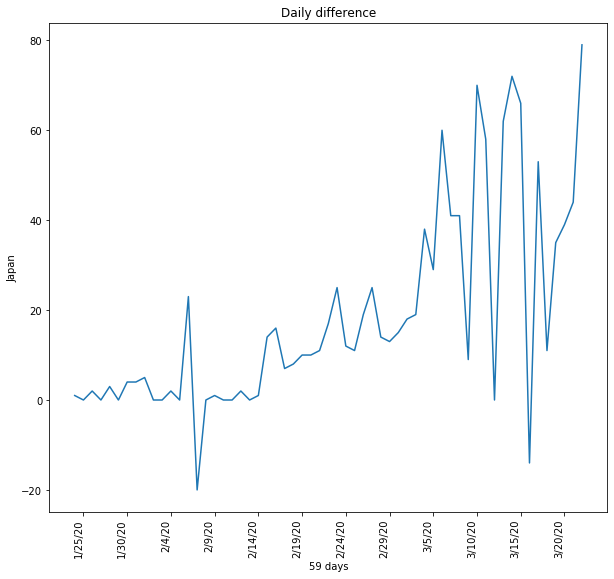

In [292]:
plot_difference(daily_difference, "Japan", 60)

!!!!China had an increase of 15136 cases on 2/13/20!!! maybe the highest in a day

In [ ]:
#DEcreased rates: SK, China, 